In [2]:
import sys
import os
sys.path.append('../../')

import data.loader

import wandb

wandb.init(project="rbfnn", config={
    "learning_rate": 1e-3,
    "epochs": 100,
    "batch_size": 64,
    "hidden_dim": 128,
    "num_centers": 10
})

(
    (train, train_y),
    (test, test_y),
    (val, val_y),
    (one_hot_encoder_X, one_hot_encoder_y),
    (train_df, test_df, _),
    (train_dataset, test_dataset, _),
    (train_loader, test_loader, _)
) = data.loader.encode_and_partition(
    data.loader.diabetic_data_raw, batch_size=wandb.config.batch_size, labelled=True
)

for batch in test_loader:
    test_eval_batch = batch[0].view(-1, train.shape[1]).cuda()
    test_eval_batch_label = batch[1].cuda()
    break

/scratch/u1319464/miniforge3/envs/diabetes/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Currently logged in as: charles-s-strauss (charles-s-strauss-n-a). Use `wandb login --relogin` to force relogin


In [3]:
train.shape

(81395, 2831)

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class RBFLayer(nn.Module):
    def __init__(self, input_dim, num_centers, beta=1.0):
        super(RBFLayer, self).__init__()
        self.num_centers = num_centers
        self.centers = nn.Parameter(torch.randn(num_centers, input_dim))
        self.beta = nn.Parameter(torch.full((num_centers,), beta))
        
    def forward(self, x):
        # Calculate the pairwise squared Euclidean distance
        expanded_x = x.unsqueeze(1).expand(-1, self.num_centers, -1)
        distances = torch.sum((expanded_x - self.centers) ** 2, dim=2)
        # Apply Gaussian RBF
        rbf_activations = torch.exp(-self.beta * distances)
        return rbf_activations




In [ ]:
input_dim = train.shape[1]
num_centers = wandb.config.num_centers
output_dim = 3
hidden_dim = wandb.config.hidden_dim
learning_rate = wandb.config.learning_rate
num_epochs = wandb.config.epochs

rbf = RBFLayer(hidden_dim, num_centers, beta=0.5)
model = nn.Sequential(
    # nn.Linear(input_dim, hidden_dim),
    rbf,
    nn.Linear(num_centers, output_dim)
)

from sklearn.cluster import KMeans
# initialize centers using k-means
kmeans = KMeans(n_clusters=num_centers).fit(train.toarray())
rbf.centers.data = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)

In [6]:

model.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    for batch in train_loader:
        inputs = batch[0].view(-1, input_dim).cuda()
        target = batch[1].view(-1, output_dim).cuda()
        outputs = model(inputs)
        loss = criterion(outputs, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.cpu().detach().item()

    avg_loss = epoch_loss / len(train_loader)
    model.eval()
    test_loss = criterion(
        model(torch.tensor(test_eval_batch).float().cuda()), test_eval_batch_label
    ).detach().cpu().item()
    wandb.log({"loss": avg_loss, "test_loss": test_loss})
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


/tmp/ipykernel_3606332/2259683569.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model(torch.tensor(test_eval_batch).float().cuda()), test_eval_batch_label


Epoch [1/100], Loss: 0.1829
Epoch [2/100], Loss: 0.1807
Epoch [3/100], Loss: 0.1792
Epoch [4/100], Loss: 0.1782
Epoch [5/100], Loss: 0.1777
Epoch [6/100], Loss: 0.1773
Epoch [7/100], Loss: 0.1771
Epoch [8/100], Loss: 0.1768
Epoch [9/100], Loss: 0.1766
Epoch [10/100], Loss: 0.1765
Epoch [11/100], Loss: 0.1763
Epoch [12/100], Loss: 0.1762
Epoch [13/100], Loss: 0.1762
Epoch [14/100], Loss: 0.1760
Epoch [15/100], Loss: 0.1759
Epoch [16/100], Loss: 0.1759
Epoch [17/100], Loss: 0.1761
Epoch [18/100], Loss: 0.1757
Epoch [19/100], Loss: 0.1756
Epoch [20/100], Loss: 0.1755
Epoch [21/100], Loss: 0.1756
Epoch [22/100], Loss: 0.1757
Epoch [23/100], Loss: 0.1754
Epoch [24/100], Loss: 0.1753
Epoch [25/100], Loss: 0.1755
Epoch [26/100], Loss: 0.1752
Epoch [27/100], Loss: 0.1751
Epoch [28/100], Loss: 0.1753
Epoch [29/100], Loss: 0.1750
Epoch [30/100], Loss: 0.1750
Epoch [31/100], Loss: 0.1748
Epoch [32/100], Loss: 0.1750
Epoch [33/100], Loss: 0.1750
Epoch [34/100], Loss: 0.1749
Epoch [35/100], Loss: 0

In [7]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

testY_proba = test_y
y_pred_proba = model(torch.tensor(test.toarray()).float().cuda()).detach().cpu().numpy()

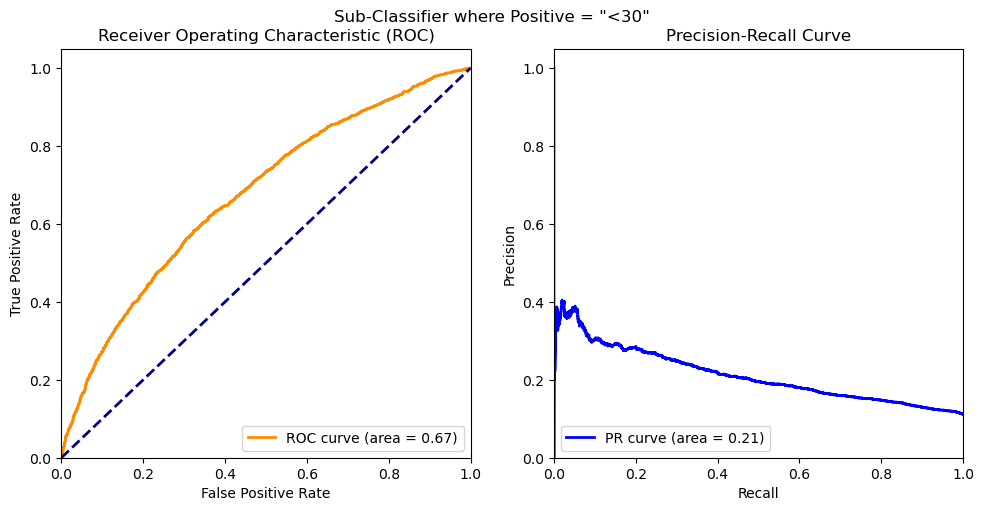

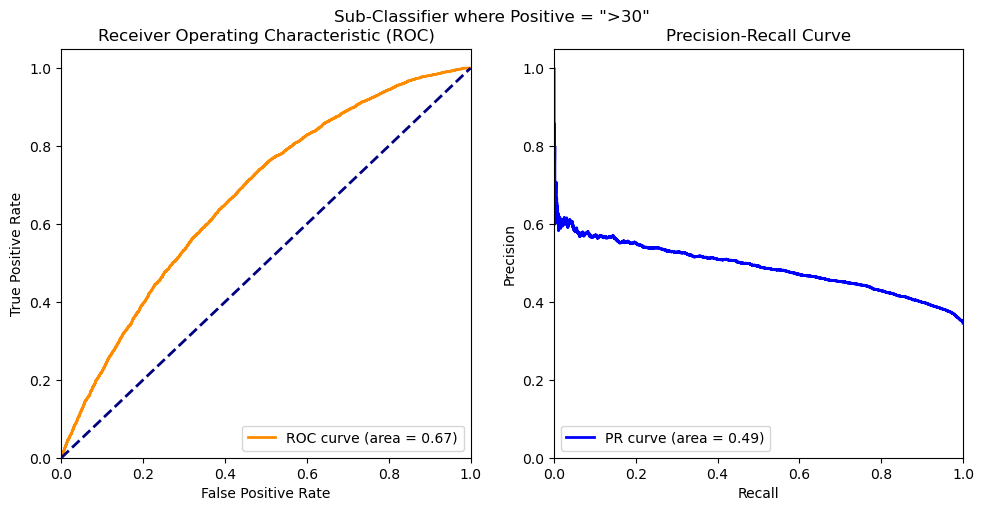

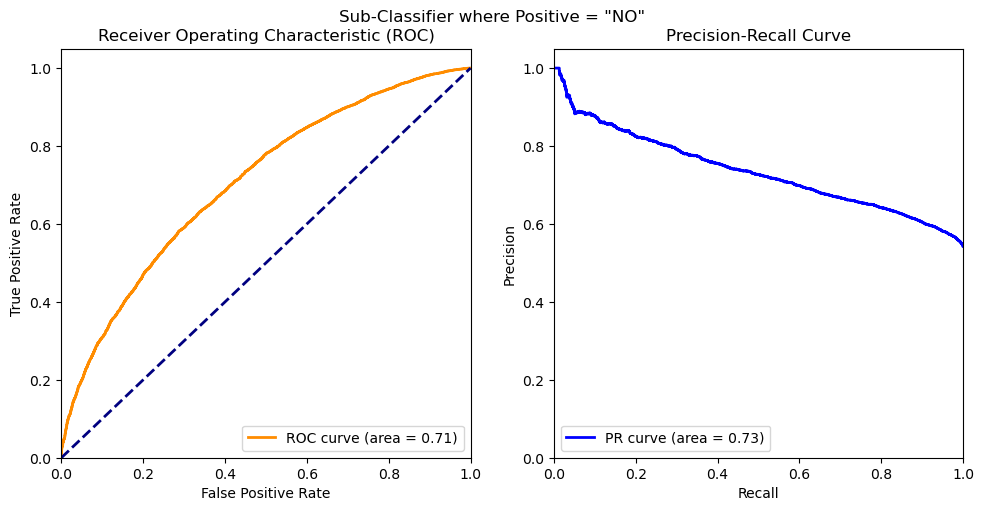

In [8]:
for i, category_value in enumerate(one_hot_encoder_y.categories_[0]):

    y_pred = y_pred_proba[:,i]
    
    testY = testY_proba[:,i]
    
    fpr, tpr, _ = roc_curve(testY, y_pred, pos_label=1)
    precision, recall, _ = precision_recall_curve(testY, y_pred)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)
    
    fig, (roc, prc) = plt.subplots(1, 2, figsize=(10, 5))
    
    plt.suptitle(f'Sub-Classifier where Positive = "{category_value}"')
    
    roc.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    roc.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    roc.set_xlim([0.0, 1.0])
    roc.set_ylim([0.0, 1.05])
    roc.set_xlabel('False Positive Rate')
    roc.set_ylabel('True Positive Rate')
    roc.set_title('Receiver Operating Characteristic (ROC)')
    roc.set_box_aspect(1)
    roc.legend(loc="lower right")
    
    prc.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    prc.set_xlim([0.0, 1.0])
    prc.set_ylim([0.0, 1.05])
    prc.set_xlabel('Recall')
    prc.set_ylabel('Precision')
    prc.set_title('Precision-Recall Curve')
    prc.set_box_aspect(1)
    prc.legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()

In [51]:

import shap

explainer = shap.GradientExplainer(model, torch.tensor(train[:1000].toarray(), dtype=torch.float32).cuda())

patient_data = torch.tensor(train.toarray()[1001:2001], dtype=torch.float32).cuda()
shap_values = explainer.shap_values(patient_data)
base_value = model(patient_data).detach().cpu().numpy().mean(axis=0)
shap.initjs()
shap.summary_plot(shap_values)

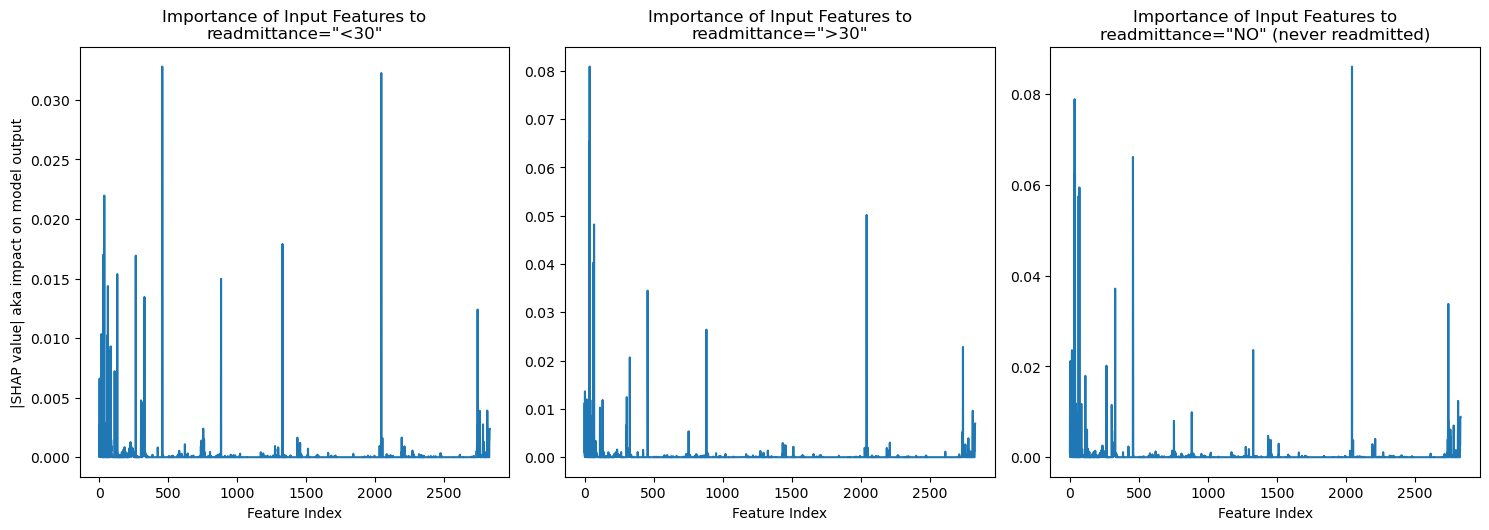

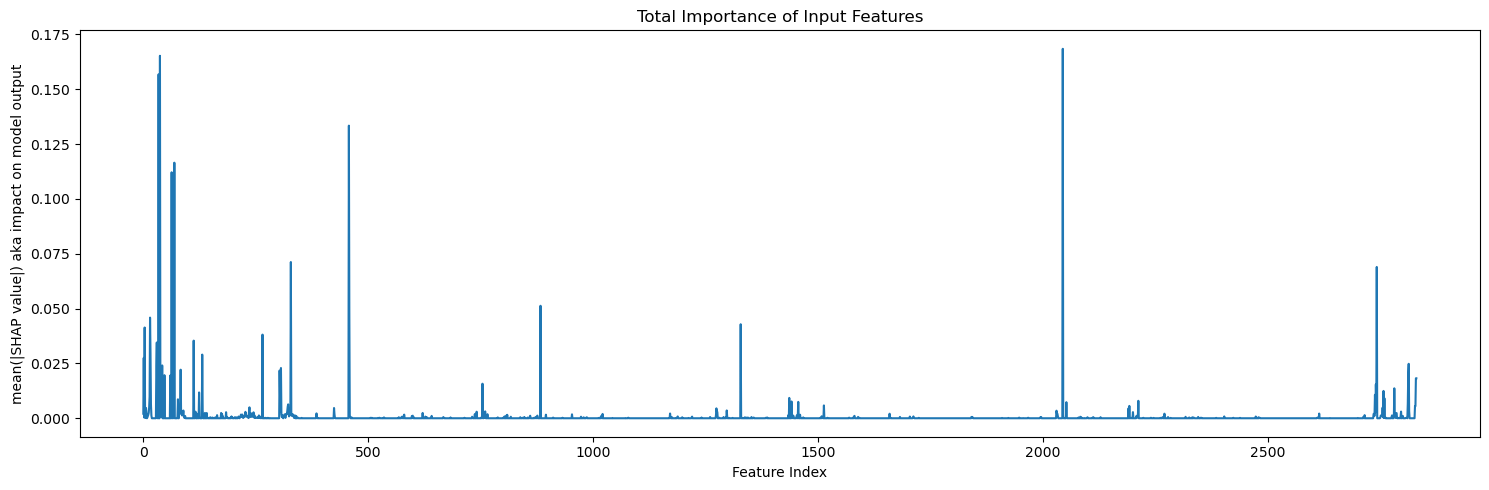

Feature Indexes Decoded. Top 15 important features shown for each classification.
readmitted="<30"
1:	payer_code
2:	nateglinide
3:	metformin-pioglitazone
4:	weight
5:	metformin-rosiglitazone
6:	glimepiride-pioglitazone
7:	glipizide-metformin
8:	glyburide-metformin
9:	tolbutamide
10:	acetohexamide
11:	chlorpropamide
12:	miglitol
13:	repaglinide
14:	pioglitazone
15:	troglitazone
readmitted=">30"
1:	acetohexamide
2:	chlorpropamide
3:	metformin-pioglitazone
4:	weight
5:	metformin-rosiglitazone
6:	glimepiride-pioglitazone
7:	glipizide-metformin
8:	glyburide-metformin
9:	payer_code
10:	tolbutamide
11:	miglitol
12:	repaglinide
13:	nateglinide
14:	troglitazone
15:	pioglitazone
readmitted="NO"
1:	acetohexamide
2:	chlorpropamide
3:	metformin-pioglitazone
4:	weight
5:	metformin-rosiglitazone
6:	glimepiride-pioglitazone
7:	glipizide-metformin
8:	glyburide-metformin
9:	payer_code
10:	tolbutamide
11:	miglitol
12:	repaglinide
13:	nateglinide
14:	troglitazone
15:	tolazamide


In [65]:
fig, (lt30, gt30, never) = plt.subplots(1, 3, figsize=(15, 5))

lt30.set_title('Importance of Input Features to\nreadmittance="<30"')
lt30.plot(np.abs(shap_values[0][0]))
lt30.set_box_aspect(1)
lt30.set_ylabel('|SHAP value| aka impact on model output')
lt30.set_xlabel('Feature Index')

gt30.set_title('Importance of Input Features to\nreadmittance=">30"')
gt30.plot(np.abs(shap_values[1][0]))
gt30.set_box_aspect(1)
gt30.set_xlabel('Feature Index')

never.set_title('Importance of Input Features to\nreadmittance="NO" (never readmitted)')
never.plot(np.abs(shap_values[2][0]))
never.set_box_aspect(1)
never.set_xlabel('Feature Index')

plt.tight_layout()
plt.show()

fig, (total) = plt.subplots(1, 1, figsize=(15, 5))

total.set_title('Total Importance of Input Features')
total.plot(np.abs(shap_values[0][0]) + np.abs(shap_values[1][0]) + np.abs(shap_values[2][0]))
total.set_ylabel('mean(|SHAP value|) aka impact on model output')
total.set_xlabel('Feature Index')


plt.tight_layout()
plt.show()

# decode input feature indexes to their feature names
# rank by total importance assigend to all encoded indexes of that feature

print('Feature Indexes Decoded. Top 15 important features shown for each classification.')
for y_i, y_value in enumerate(one_hot_encoder_y.categories_[0]):
    i = 0
    sums = []
    importances = np.abs(shap_values[y_i][0])
    for cat_i, cat_name in enumerate(one_hot_encoder_X.feature_names_in_):
        cat_len = len(one_hot_encoder_X.categories_[cat_i])
        sums.append(sum(importances[i:i+cat_len]))
        i += cat_len
    print(f'readmitted="{y_value}"')
    for i, r in enumerate(one_hot_encoder_X.feature_names_in_[np.argsort(sums)][:15]):
        print(f'{i+1}:\t{r}')